In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from pyMSpec import centroid_detection
from sklearn import linear_model
import scipy

In [2]:
# Load data
from pyImagingMSpec import inMemoryIMS
file_in = '/Users/palmer/Documents/tmp_data/ClaireCarter_ratBrain/FixedTissue_leap8cyc_2-_10_08SET1(081020,16h25m).imzML'
ims_dataset = inMemoryIMS.inMemoryIMS(file_in, norm=[], spectrum_type='profile')

TODO: convert indices into real world coordinates
loaded spectra
file loaded


<IPython.core.display.Javascript object>


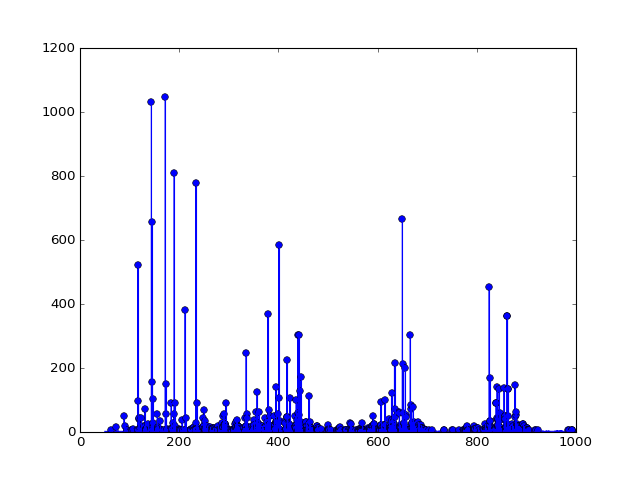

In [48]:
n = 17757
spec = ims_dataset.get_spectrum(n).smooth_spectrum(method_args={'w_size':7}).get_spectrum(source='profile')
spec_c = centroid_detection.gradient(np.asarray(spec[0]),np.asarray(spec[1]),weighted_bins=3, min_intensity=5)
plt.figure()
plt.plot(spec[0],spec[1])
plt.stem(spec_c[0],spec_c[1])
plt.show()

<IPython.core.display.Javascript object>


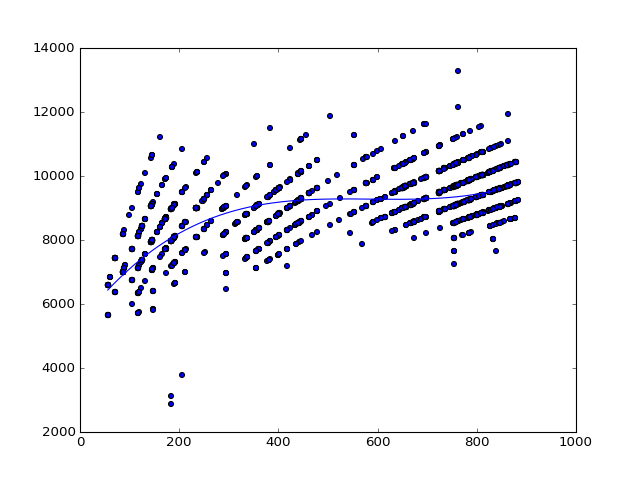

Coeffs: [[  0.00000000e+00   2.00985416e+01  -3.45728120e-02   1.96598336e-05]]x5415.92


<IPython.core.display.Javascript object>


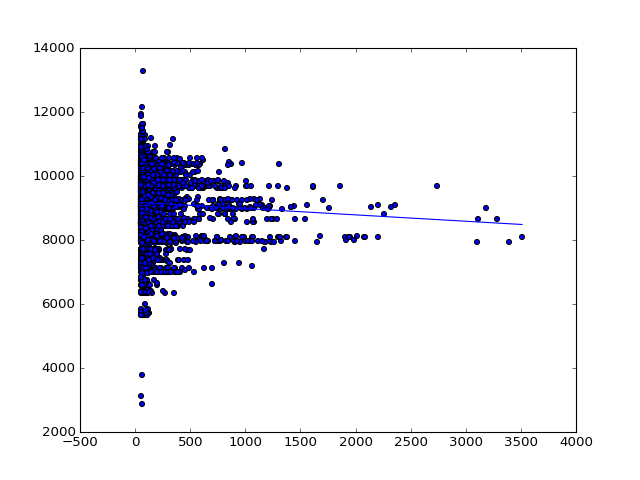

In [31]:
# Resolving power
import copy
from scipy import signal
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
n_spec = 50 # number of spectra to analyse
rp = []
mz = []
val = []
for n in np.random.choice(range(len(ims_dataset.index_list)),n_spec, replace=False):
    spec = ims_dataset.get_spectrum(n).smooth_spectrum(method_args={'w_size':7}).get_spectrum(source='profile')
    spec_c = centroid_detection.gradient(np.asarray(spec[0]),np.asarray(spec[1]),weighted_bins=5, min_intensity=50)
    mzs = spec[0]
    ints = spec[1]
    for mz_c, int_c, idx_c in zip(spec_c[0], spec_c[1], spec_c[2]):
        idx_l = copy.copy(idx_c)
        while ints[idx_l] >= int_c/2.:
            idx_l -=1
        idx_r = copy.copy(idx_c)
        while ints[idx_r] >= int_c/2.:
            idx_r +=1
        rp.append(mz_c/(np.mean([abs(mz_c- mzs[idx_r]), abs(mz_c- mzs[idx_l])])))
        mz.append(mz_c)
        val.append(int_c)

# view fit
plt.figure()
plt.scatter(np.asarray(mz), np.asarray(rp))
model = make_pipeline(PolynomialFeatures(3), linear_model.RANSACRegressor())
model.fit(np.asarray(mz).reshape((len(mz),1)), np.asarray(rp).reshape((len(rp),1)))
line_X = np.arange(spec_c[0][0], spec_c[0][-1])
line_y_ransac = model.predict(line_X[:, np.newaxis])
plt.plot(line_X, line_y_ransac)
plt.show()
print "Coeffs: {}x{:3.2f}".format(model.named_steps['ransacregressor'].estimator_.coef_, model.named_steps['ransacregressor'].estimator_.intercept_[0])

plt.figure()
plt.scatter(np.asarray(val), np.asarray(rp))
model = make_pipeline(PolynomialFeatures(1), linear_model.RANSACRegressor())
model.fit(np.asarray(val).reshape((len(val),1)), np.asarray(rp).reshape((len(rp),1)))
line_X = np.arange(min(val), max(val))
line_y_ransac = model.predict(line_X[:, np.newaxis])
plt.plot(line_X, line_y_ransac)
plt.show()


bad spectrum for 107
bad spectrum for 328
bad spectrum for 888
bad spectrum for 106
bad spectrum for 221
bad spectrum for 220
bad spectrum for 444
bad spectrum for 332


<IPython.core.display.Javascript object>


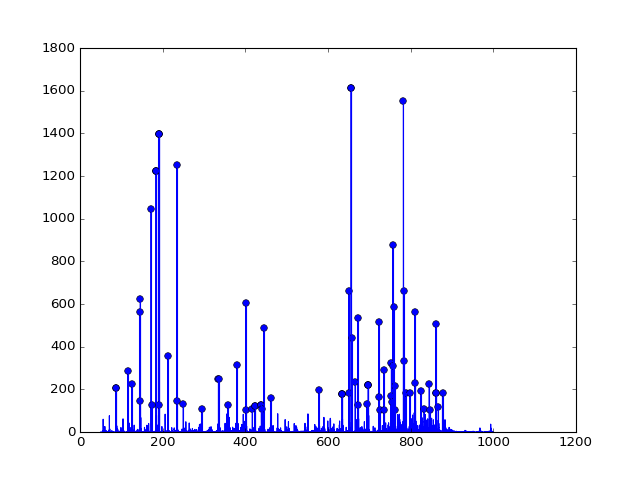

<IPython.core.display.Javascript object>


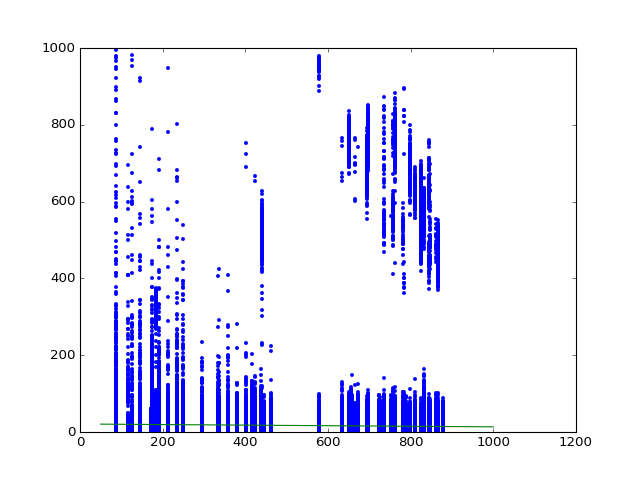

(314390,)


In [46]:
# Mass Accurary
def find_closest(A, target):
    #A must be sorted
    idx = A.searchsorted(target)
    idx = np.clip(idx, 1, len(A)-1)
    left = A[idx-1]
    right = A[idx]
    idx -= target - left < right - target
    return A[idx]
mean_spec = ims_dataset.generate_summary_spectrum('mean',ppm=35)
mean_spec_c = centroid_detection.gradient(np.asarray(mean_spec[0]),np.asarray(mean_spec[1]), weighted_bins=5, min_intensity=100)
n_sample=5000
ppm_diff=[]
mzs = []
for ii in np.random.choice(ims_dataset.index_list,n_sample,replace=False):
    spec = ims_dataset.get_spectrum(ii).smooth_spectrum(method_args={'w_size':7}).get_spectrum(source='profile')        
    spec_c = centroid_detection.gradient(spec[0],spec[1],weighted_bins=5, min_intensity=10)
    if sum(spec[1]) < 10000: # hack to catch low quality spectra
        print "bad spectrum for {}".format(ii)
        continue
    for mz in mean_spec_c[0]:
        mz_ = find_closest(spec_c[0], mz)
        delta_ppm = 1e6*(mz_-mz)/mz
        if abs(delta_ppm) < 1000:
            ppm_diff.append(delta_ppm)
            mzs.append(mz)

<IPython.core.display.Javascript object>


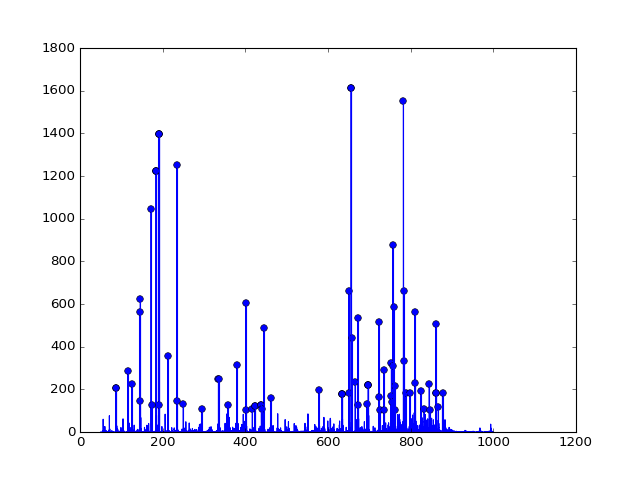

<IPython.core.display.Javascript object>


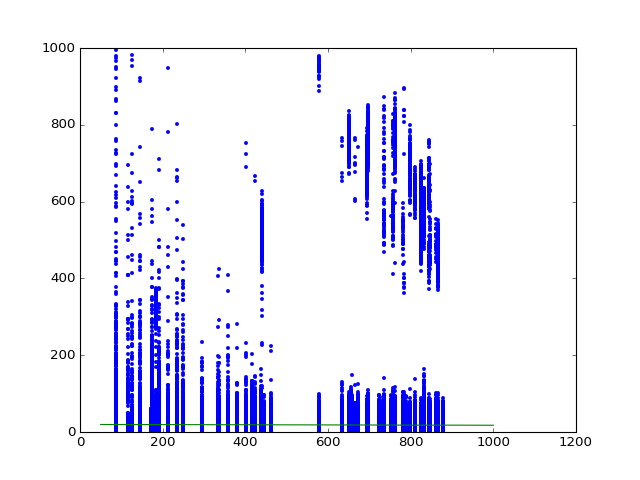

(314390,)


In [47]:
plt.figure()
plt.plot(mean_spec[0],mean_spec[1])
plt.stem(mean_spec_c[0],mean_spec_c[1])
plt.show()
plt.figure()
plt.plot(mzs,np.abs(ppm_diff),'.')
model = make_pipeline(PolynomialFeatures(1), linear_model.RANSACRegressor())
model.fit(np.asarray(mzs).reshape((len(mzs),1)), np.asarray(np.abs(ppm_diff)).reshape((len(ppm_diff),1)))
line_X = np.arange(mean_spec[0][0], mean_spec[0][-1])
line_y_ransac = model.predict(line_X[:, np.newaxis])
plt.plot(line_X, line_y_ransac)
plt.show()
print np.shape(mzs)